In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from meteostat import Point, Daily
import scipy.stats as stats

from IPython.display import display
pd.set_option('display.max_columns', None)


# 1-Data Okuma & Düzenleme

In [127]:
med = pd.read_csv("med.csv")
train = pd.read_csv("train.csv")
sample = pd.read_csv("sample_submission.csv")
t_calendar = pd.read_csv("Turkish_Calendar.csv")
Elektrik_Fiyat = pd.read_excel("Elektrik_Fiyatları.xlsx")
Turist_Say = pd.read_excel("Turist_Sayısı.xlsx")
Tesis_Sayisi = pd.read_excel("Tesisi_Sayisi.xlsx")

In [4]:
train["Tarih"] = pd.to_datetime(train["Tarih"])
med["Tarih"] = pd.to_datetime(med["Tarih"])
sample["Tarih"] = pd.to_datetime(sample["Tarih"])

## 1.1.Data tarih detay ekleme.

In [5]:
t_calendar.head()

,CALENDAR_SK,CALENDAR_DATE,DAY_OF_MONTH,DAY_OF_WEEK_SK,SEASON_SK,QUARTER_OF_YEAR,MONTH_SK,WEEKEND_FLAG,WEEK_OF_YEAR,RAMADAN_FLAG,RELIGIOUS_DAY_FLAG_SK,NATIONAL_DAY_FLAG_SK,PUBLIC_HOLIDAY_FLAG,SPECIAL_DAY_SK,SPECIAL_DAY_SK2
0,20241231,2024-12-31,31,2,4,4,202412,N,53,N,100,200,N,NaN,NaN
1,20241230,2024-12-30,30,1,4,4,202412,N,53,N,100,200,N,NaN,NaN
2,20241229,2024-12-29,29,7,4,4,202412,Y,53,N,100,200,Y,NaN,NaN
3,20241228,2024-12-28,28,6,4,4,202412,Y,52,N,100,200,Y,NaN,NaN
4,20241227,2024-12-27,27,5,4,4,202412,N,52,N,100,200,N,NaN,NaN


In [6]:
all_data = pd.concat([train, sample])
all_data["CALENDAR_DATE"] = all_data.Tarih.astype("string").str.slice(stop=10)
t_calendar["CALENDAR_DATE"] = t_calendar["CALENDAR_DATE"] .str.slice(stop=10)
Elektrik_Fiyat["CALENDAR_DATE"] = Elektrik_Fiyat["CALENDAR_DATE"].astype("string").str.slice(stop=10)
med["CALENDAR_DATE"] = med["Tarih"].astype("string").str.slice(stop=10)

med.drop(columns="Tarih", inplace=True)
med["IS_MED"] = 1

In [7]:
all_data = all_data.merge(t_calendar, how="left", on="CALENDAR_DATE")
all_data = all_data.merge(med, how="left", on="CALENDAR_DATE")
all_data = all_data.merge(Elektrik_Fiyat, how="left", on="CALENDAR_DATE")

all_data["IS_MED"].fillna(0, inplace=True)

all_data["TARIH_COL_1"] = all_data["Tarih"]
all_data = all_data.set_index("Tarih")



In [8]:
all_data["RAMADAN_FLAG"].replace(["Y","N"],[1,0], inplace=True)
all_data["WEEKEND_FLAG"].replace(["Y","N"],[1,0], inplace=True)
all_data["PUBLIC_HOLIDAY_FLAG"].replace(["Y","N"],[1,0], inplace=True)
all_data["HOUR"] =  all_data.index.hour
all_data["MONTH"] =  all_data.index.month
all_data["YEAR"] =  all_data.index.year

all_data = all_data.merge(Tesis_Sayisi, how="left", on="YEAR")
all_data = all_data.merge(Turist_Say, how="left", on=["YEAR", "MONTH"])

all_data["TARIH_COL"] = all_data["TARIH_COL_1"]
all_data = all_data.set_index("TARIH_COL_1")

all_data["AMOUNT"] = all_data["Dağıtılan Enerji (MWh)"]

all_data.drop(columns=["Dağıtılan Enerji (MWh)","CALENDAR_DATE", "CALENDAR_SK", "MONTH_SK","SPECIAL_DAY_SK", "SPECIAL_DAY_SK2"], inplace=True)

for col in ['DAY_OF_MONTH', 'DAY_OF_WEEK_SK', 'SEASON_SK', 'QUARTER_OF_YEAR',
       'WEEKEND_FLAG', 'WEEK_OF_YEAR', 'RAMADAN_FLAG', 'RELIGIOUS_DAY_FLAG_SK',
       'NATIONAL_DAY_FLAG_SK', 'PUBLIC_HOLIDAY_FLAG', 'MONTH', 'YEAR']:
    all_data[col] = all_data[col].astype("category")

In [9]:
all_data.head()

,DAY_OF_MONTH,DAY_OF_WEEK_SK,SEASON_SK,QUARTER_OF_YEAR,WEEKEND_FLAG,WEEK_OF_YEAR,RAMADAN_FLAG,RELIGIOUS_DAY_FLAG_SK,NATIONAL_DAY_FLAG_SK,PUBLIC_HOLIDAY_FLAG,IS_MED,TL_kWH_MESKEN,TL_kWH_TICARETHANE,TL_kWH_AKTIF_ENERJI_MESKEN_GRUBU,TL_kWH_AKTIF_ENERJI_TICARETHANE_GRUBU,TL_kWH_MESKEN_ABONE_GRUBU,TL_kWH_TICARETHANE_ABONE_GRUBU,HOUR,MONTH,YEAR,TESIS_SAYISI,KISI_SAYISI,TARIH_COL,AMOUNT
TARIH_COL_1,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,1,1,1,1,0,1,0,100,200,1,0.0,0.4482,0.452,0.2309,0.2309,0.1304,0.1336,0,1,2018,207,24330,2018-01-01 00:00:00,1593.944216
2018-01-01 01:00:00,1,1,1,1,0,1,0,100,200,1,0.0,0.4482,0.452,0.2309,0.2309,0.1304,0.1336,1,1,2018,207,24330,2018-01-01 01:00:00,1513.933887
2018-01-01 02:00:00,1,1,1,1,0,1,0,100,200,1,0.0,0.4482,0.452,0.2309,0.2309,0.1304,0.1336,2,1,2018,207,24330,2018-01-01 02:00:00,1402.612637
2018-01-01 03:00:00,1,1,1,1,0,1,0,100,200,1,0.0,0.4482,0.452,0.2309,0.2309,0.1304,0.1336,3,1,2018,207,24330,2018-01-01 03:00:00,1278.527266
2018-01-01 04:00:00,1,1,1,1,0,1,0,100,200,1,0.0,0.4482,0.452,0.2309,0.2309,0.1304,0.1336,4,1,2018,207,24330,2018-01-01 04:00:00,1220.697701


## 1.2.Hava Durumu Verileri

**Column	Description	Type**
station	The Meteostat ID of the weather station (only if query refers to multiple stations)	String

time::The date	Datetime64

tavg::The average air temperature in °C	Float64

tmin::The minimum air temperature in °C	Float64

tmax::The maximum air temperature in °C	Float64

prcp::The daily precipitation total in mm	Float64

snow::The snow depth in mm	Float64

wdir::The average wind direction in degrees (°)	Float64

wspd::The average wind speed in km/h	Float64

wpgt::The peak wind gust in km/h	Float64

pres::The average sea-level air pressure in hPa	Float64

tsun::The daily sunshine total in minutes (m)	Float64

In [10]:
from meteostat import Hourly

# Set time period
start = datetime(2018, 1, 1)
end = datetime(2022, 12, 31, 23, 59)

# Get hourly data
Izmir_Place = Point(38.423733, 27.142826) 
data_Izmir = Hourly('17219', start, end)
data_Izmir = data_Izmir.fetch()

#https://www.windy.com/station/wmo-17186?38.611,27.436,12
#2021 itibarı ile ulaştığımız için ve %15 etkisden dolayı çıkarıldı.
# Get hourly data
# Manisa_Place = Point(38.630554, 27.422222)
data_Manisa = Hourly('17218', start, end)
data_Manisa = data_Manisa.fetch()

# Print DataFrame
meteo_data_Izmir = pd.DataFrame(data_Izmir)
meteo_data_Manisa = pd.DataFrame(data_Manisa)

meteo_data_Izmir.drop(columns=["prcp", "snow", "wpgt", "tsun","coco"], inplace=True)
meteo_data_Manisa.drop(columns=["prcp", "snow", "wpgt", "tsun","coco"], inplace=True)

meteo_data_Manisa.head(15)

,temp,dwpt,rhum,wdir,wspd,pres
time,,,,,,
2018-01-01 00:00:00,2.0,0.8,92.0,360.0,0.0,1020.6
2018-01-01 01:00:00,2.0,1.0,93.0,NaN,0.0,NaN
2018-01-01 02:00:00,1.0,0.0,93.0,NaN,0.0,NaN
2018-01-01 03:00:00,0.6,-0.4,93.0,360.0,0.0,1019.9
2018-01-01 04:00:00,0.0,-1.0,93.0,320.0,5.4,NaN
2018-01-01 05:00:00,0.0,-1.0,93.0,340.0,3.6,NaN
2018-01-01 06:00:00,1.0,0.3,95.0,360.0,0.0,1020.3
2018-01-01 07:00:00,6.0,3.0,81.0,120.0,7.6,NaN
2018-01-01 08:00:00,8.0,2.0,66.0,110.0,13.0,NaN


In [11]:
all_data = all_data.merge(meteo_data_Izmir, how="left", left_index=True, right_index=True )
all_data = all_data.merge(meteo_data_Manisa, how="left", left_index=True, right_index=True, suffixes=('_IZMIR','_MANISA'))

all_data.head()

,DAY_OF_MONTH,DAY_OF_WEEK_SK,SEASON_SK,QUARTER_OF_YEAR,WEEKEND_FLAG,WEEK_OF_YEAR,RAMADAN_FLAG,RELIGIOUS_DAY_FLAG_SK,NATIONAL_DAY_FLAG_SK,PUBLIC_HOLIDAY_FLAG,IS_MED,TL_kWH_MESKEN,TL_kWH_TICARETHANE,TL_kWH_AKTIF_ENERJI_MESKEN_GRUBU,TL_kWH_AKTIF_ENERJI_TICARETHANE_GRUBU,TL_kWH_MESKEN_ABONE_GRUBU,TL_kWH_TICARETHANE_ABONE_GRUBU,HOUR,MONTH,YEAR,TESIS_SAYISI,KISI_SAYISI,TARIH_COL,AMOUNT,temp_IZMIR,dwpt_IZMIR,rhum_IZMIR,wdir_IZMIR,wspd_IZMIR,pres_IZMIR,temp_MANISA,dwpt_MANISA,rhum_MANISA,wdir_MANISA,wspd_MANISA,pres_MANISA
TARIH_COL_1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,1,1,1,1,0,1,0,100,200,1,0.0,0.4482,0.452,0.2309,0.2309,0.1304,0.1336,0,1,2018,207,24330,2018-01-01 00:00:00,1593.944216,5.2,1.9,79.0,30.0,16.6,1020.0,2.0,0.8,92.0,360.0,0.0,1020.6
2018-01-01 01:00:00,1,1,1,1,0,1,0,100,200,1,0.0,0.4482,0.452,0.2309,0.2309,0.1304,0.1336,1,1,2018,207,24330,2018-01-01 01:00:00,1513.933887,7.0,1.1,66.0,40.0,16.6,1019.0,2.0,1.0,93.0,NaN,0.0,NaN
2018-01-01 02:00:00,1,1,1,1,0,1,0,100,200,1,0.0,0.4482,0.452,0.2309,0.2309,0.1304,0.1336,2,1,2018,207,24330,2018-01-01 02:00:00,1402.612637,4.0,1.0,81.0,360.0,11.2,1019.0,1.0,0.0,93.0,NaN,0.0,NaN
2018-01-01 03:00:00,1,1,1,1,0,1,0,100,200,1,0.0,0.4482,0.452,0.2309,0.2309,0.1304,0.1336,3,1,2018,207,24330,2018-01-01 03:00:00,1278.527266,3.5,0.9,83.0,10.0,13.0,1020.0,0.6,-0.4,93.0,360.0,0.0,1019.9
2018-01-01 04:00:00,1,1,1,1,0,1,0,100,200,1,0.0,0.4482,0.452,0.2309,0.2309,0.1304,0.1336,4,1,2018,207,24330,2018-01-01 04:00:00,1220.697701,2.0,1.0,93.0,250.0,3.6,1019.0,0.0,-1.0,93.0,320.0,5.4,NaN


In [12]:
izmir_nufus = pd.read_html('https://www.nufusu.com/il/izmir-nufusu')[1]
izmir_nufus_yogunlugu = pd.read_html('https://www.nufusu.com/il/izmir-nufusu')[2]
izmir_nufus_yogunlugu.drop(columns=["İzmir Nüfusu"], inplace=True)
izmir_merge = izmir_nufus.merge(izmir_nufus_yogunlugu, how="left", on="Yıl")
izmir_merge.rename(columns={"Yıl": "YEAR", "Nüfus Yoğunluğu": "İzmir Nüfus Yoğunluğu", "Artış Hızı": "İzmir Nüfus Artış Hızı"}, inplace=True)

manisa_nufus = pd.read_html('https://www.nufusu.com/il/manisa-nufusu')[1]
manisa_nufus_yogunlugu = pd.read_html('https://www.nufusu.com/il/manisa-nufusu')[2]
manisa_nufus_yogunlugu.drop(columns=["Manisa Nüfusu"], inplace=True)
manisa_merge = manisa_nufus.merge(manisa_nufus_yogunlugu, how="left", on="Yıl")
manisa_merge.rename(columns={"Yıl": "YEAR", "Nüfus Yoğunluğu": "Manisa Nüfus Yoğunluğu", "Artış Hızı": "Manisa Nüfus Artış Hızı"}, inplace=True)

display(izmir_merge.head(10))
display(manisa_merge.head(10))

,YEAR,İzmir Nüfusu,İzmir Nüfus Artış Hızı,İzmir Nüfus Yoğunluğu
0,2014,4.113.072,% 1.28,343 /km2
1,2015,4.168.415,% 1.35,347 /km2
2,2016,4.223.545,% 1.32,352 /km2
3,2017,4.279.677,% 1.33,356 /km2
4,2018,4.320.519,% 0.95,360 /km2
5,2019,4.367.251,% 1.08,364 /km2
6,2020,4.394.694,% 0.63,366 /km2
7,2021,4.425.789,% 0.71,369 /km2
8,2022,4.462.056,% 0.82,372 /km2


,YEAR,Manisa Nüfusu,Manisa Nüfus Artış Hızı,Manisa Nüfus Yoğunluğu
0,2014,1.367.905,% 0.62,103 /km2
1,2015,1.380.366,% 0.91,104 /km2
2,2016,1.396.945,% 1.20,105 /km2
3,2017,1.413.041,% 1.15,106 /km2
4,2018,1.429.643,% 1.17,108 /km2
5,2019,1.440.611,% 0.77,109 /km2
6,2020,1.450.616,% 0.69,109 /km2
7,2021,1.456.626,% 0.41,110 /km2
8,2022,1.468.279,% 0.80,111 /km2


In [13]:
izmir_merge["İzmir Nüfusu"] = (izmir_merge["İzmir Nüfusu"].apply(lambda element: element.replace(".", ""))).astype(float)
izmir_merge["İzmir Nüfus Artış Hızı"] = (izmir_merge["İzmir Nüfus Artış Hızı"].apply(lambda element: element.replace("% ", ""))).astype(float)
izmir_merge["İzmir Nüfus Yoğunluğu"] = izmir_merge["İzmir Nüfus Yoğunluğu"].apply(lambda element: element.replace(" /km2", "")).astype(float)

manisa_merge["Manisa Nüfusu"] = (manisa_merge["Manisa Nüfusu"].apply(lambda element: element.replace(".", ""))).astype(float)
manisa_merge["Manisa Nüfus Artış Hızı"] = (manisa_merge["Manisa Nüfus Artış Hızı"].apply(lambda element: element.replace("% ", ""))).astype(float)
manisa_merge["Manisa Nüfus Yoğunluğu"] = manisa_merge["Manisa Nüfus Yoğunluğu"].apply(lambda element: element.replace(" /km2", "")).astype(float)

all_data = all_data.merge(izmir_merge, how="left", on="YEAR")
all_data = all_data.merge(manisa_merge, how="left", on="YEAR")
all_data.head(5)

,DAY_OF_MONTH,DAY_OF_WEEK_SK,SEASON_SK,QUARTER_OF_YEAR,WEEKEND_FLAG,WEEK_OF_YEAR,RAMADAN_FLAG,RELIGIOUS_DAY_FLAG_SK,NATIONAL_DAY_FLAG_SK,PUBLIC_HOLIDAY_FLAG,IS_MED,TL_kWH_MESKEN,TL_kWH_TICARETHANE,TL_kWH_AKTIF_ENERJI_MESKEN_GRUBU,TL_kWH_AKTIF_ENERJI_TICARETHANE_GRUBU,TL_kWH_MESKEN_ABONE_GRUBU,TL_kWH_TICARETHANE_ABONE_GRUBU,HOUR,MONTH,YEAR,TESIS_SAYISI,KISI_SAYISI,TARIH_COL,AMOUNT,temp_IZMIR,dwpt_IZMIR,rhum_IZMIR,wdir_IZMIR,wspd_IZMIR,pres_IZMIR,temp_MANISA,dwpt_MANISA,rhum_MANISA,wdir_MANISA,wspd_MANISA,pres_MANISA,İzmir Nüfusu,İzmir Nüfus Artış Hızı,İzmir Nüfus Yoğunluğu,Manisa Nüfusu,Manisa Nüfus Artış Hızı,Manisa Nüfus Yoğunluğu
0,1,1,1,1,0,1,0,100,200,1,0.0,0.4482,0.452,0.2309,0.2309,0.1304,0.1336,0,1,2018,207,24330,2018-01-01 00:00:00,1593.944216,5.2,1.9,79.0,30.0,16.6,1020.0,2.0,0.8,92.0,360.0,0.0,1020.6,4320519.0,0.95,360.0,1429643.0,1.17,108.0
1,1,1,1,1,0,1,0,100,200,1,0.0,0.4482,0.452,0.2309,0.2309,0.1304,0.1336,1,1,2018,207,24330,2018-01-01 01:00:00,1513.933887,7.0,1.1,66.0,40.0,16.6,1019.0,2.0,1.0,93.0,NaN,0.0,NaN,4320519.0,0.95,360.0,1429643.0,1.17,108.0
2,1,1,1,1,0,1,0,100,200,1,0.0,0.4482,0.452,0.2309,0.2309,0.1304,0.1336,2,1,2018,207,24330,2018-01-01 02:00:00,1402.612637,4.0,1.0,81.0,360.0,11.2,1019.0,1.0,0.0,93.0,NaN,0.0,NaN,4320519.0,0.95,360.0,1429643.0,1.17,108.0
3,1,1,1,1,0,1,0,100,200,1,0.0,0.4482,0.452,0.2309,0.2309,0.1304,0.1336,3,1,2018,207,24330,2018-01-01 03:00:00,1278.527266,3.5,0.9,83.0,10.0,13.0,1020.0,0.6,-0.4,93.0,360.0,0.0,1019.9,4320519.0,0.95,360.0,1429643.0,1.17,108.0
4,1,1,1,1,0,1,0,100,200,1,0.0,0.4482,0.452,0.2309,0.2309,0.1304,0.1336,4,1,2018,207,24330,2018-01-01 04:00:00,1220.697701,2.0,1.0,93.0,250.0,3.6,1019.0,0.0,-1.0,93.0,320.0,5.4,NaN,4320519.0,0.95,360.0,1429643.0,1.17,108.0


## 1.3.Kategorik tipli değişkenlerin düzenlenmesi

In [14]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40896 entries, 0 to 40895
Data columns (total 42 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   DAY_OF_MONTH                           40896 non-null  category      
 1   DAY_OF_WEEK_SK                         40896 non-null  category      
 2   SEASON_SK                              40896 non-null  category      
 3   QUARTER_OF_YEAR                        40896 non-null  category      
 4   WEEKEND_FLAG                           40896 non-null  category      
 5   WEEK_OF_YEAR                           40896 non-null  category      
 6   RAMADAN_FLAG                           40896 non-null  category      
 7   RELIGIOUS_DAY_FLAG_SK                  40896 non-null  category      
 8   NATIONAL_DAY_FLAG_SK                   40896 non-null  category      
 9   PUBLIC_HOLIDAY_FLAG                    40896 non-null  catego

In [15]:
kategorik_col =  ['DAY_OF_MONTH', 'DAY_OF_WEEK_SK', 'SEASON_SK', 'QUARTER_OF_YEAR','WEEKEND_FLAG', 'WEEK_OF_YEAR', 'RAMADAN_FLAG', 'RELIGIOUS_DAY_FLAG_SK',
       'NATIONAL_DAY_FLAG_SK', 'PUBLIC_HOLIDAY_FLAG', 'IS_MED', 'HOUR',
       'MONTH']
for col in kategorik_col:
  all_data[col] = all_data[col].astype(int)


## 1.4.Boş değerlerin KNN ile doldurulması

In [16]:
all_data.describe()

,DAY_OF_MONTH,DAY_OF_WEEK_SK,SEASON_SK,QUARTER_OF_YEAR,WEEKEND_FLAG,WEEK_OF_YEAR,RAMADAN_FLAG,RELIGIOUS_DAY_FLAG_SK,NATIONAL_DAY_FLAG_SK,PUBLIC_HOLIDAY_FLAG,IS_MED,TL_kWH_MESKEN,TL_kWH_TICARETHANE,TL_kWH_AKTIF_ENERJI_MESKEN_GRUBU,TL_kWH_AKTIF_ENERJI_TICARETHANE_GRUBU,TL_kWH_MESKEN_ABONE_GRUBU,TL_kWH_TICARETHANE_ABONE_GRUBU,HOUR,MONTH,YEAR,KISI_SAYISI,TARIH_COL,AMOUNT,temp_IZMIR,dwpt_IZMIR,rhum_IZMIR,wdir_IZMIR,wspd_IZMIR,pres_IZMIR,temp_MANISA,dwpt_MANISA,rhum_MANISA,wdir_MANISA,wspd_MANISA,pres_MANISA,İzmir Nüfusu,İzmir Nüfus Artış Hızı,İzmir Nüfus Yoğunluğu,Manisa Nüfusu,Manisa Nüfus Artış Hızı,Manisa Nüfus Yoğunluğu
count,40896.000000,40896.000000,40896.000000,40896.000000,40896.000000,40896.000000,40896.000000,40896.000000,40896.000000,40896.000000,40896.000000,40896.000000,40896.000000,40896.000000,40896.000000,40896.000000,40896.000000,40896.000000,40896.000000,40896.000000,40896.000000,40896,40896.000000,40894.000000,40894.000000,40894.000000,40554.000000,40893.000000,40808.000000,40289.000000,40287.000000,40287.000000,36244.000000,40289.000000,28602.000000,4.089600e+04,40896.000000,40896.000000,4.089600e+04,40896.000000,40896.000000
mean,15.725939,3.996479,2.419601,2.419601,0.285211,25.803404,0.087441,101.170775,200.026995,0.311620,0.017606,0.865291,1.164519,0.505362,0.717968,0.216032,0.221175,11.500000,6.238263,2019.856808,76780.519953,2020-05-01 23:30:00,1803.389228,17.806644,9.378784,62.406490,209.647310,16.591747,1013.509033,18.225779,9.991978,62.075608,192.594802,12.415513,1014.134651,4.389194e+06,0.839167,365.784624,1.447787e+06,0.765663,109.285211
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,100.000000,200.000000,0.000000,0.000000,0.448200,0.452000,0.230900,0.230900,0.126500,0.129000,0.000000,1.000000,2018.000000,30.000000,2018-01-01 00:00:00,0.000000,-6.000000,-14.000000,2.000000,0.000000,0.000000,993.000000,-5.000000,-15.000000,12.000000,0.000000,0.000000,991.000000,4.320519e+06,0.630000,360.000000,1.429643e+06,0.410000,108.000000
25%,8.000000,2.000000,1.000000,1.000000,0.000000,13.000000,0.000000,100.000000,200.000000,0.000000,0.000000,0.547900,0.714800,0.302700,0.415000,0.154000,0.157600,5.750000,3.000000,2019.000000,24175.000000,2019-03-02 23:45:00,1476.704767,11.000000,5.900000,45.000000,110.000000,5.400000,1009.000000,12.000000,6.100000,48.000000,80.000000,5.400000,1010.000000,4.367251e+06,0.710000,364.000000,1.440611e+06,0.690000,109.000000
50%,16.000000,4.000000,2.000000,2.000000,0.000000,25.000000,0.000000,100.000000,200.000000,0.000000,0.000000,0.710200,0.945000,0.362700,0.542100,0.212400,0.217200,11.500000,6.000000,2020.000000,41652.000000,2020-05-01 23:30:00,1803.483433,17.000000,10.100000,61.000000,200.000000,16.600000,1013.000000,18.000000,10.800000,63.000000,200.000000,11.200000,1013.500000,4.394694e+06,0.820000,366.000000,1.450616e+06,0.770000,109.000000
75%,23.000000,6.000000,3.000000,3.000000,1.000000,38.000000,0.000000,100.000000,200.000000,1.000000,0.000000,0.916000,1.217000,0.474300,0.706300,0.265100,0.271100,17.250000,9.000000,2021.000000,126748.000000,2021-07-01 23:15:00,2122.347112,25.000000,13.900000,81.000000,350.000000,25.900000,1017.000000,25.000000,14.800000,77.000000,320.000000,18.400000,1018.000000,4.425789e+06,0.950000,369.000000,1.456626e+06,0.800000,110.000000
max,31.000000,7.000000,4.000000,4.000000,1.000000,53.000000,1.000000,163.000000,204.000000,1.000000,1.000000,2.170000,3.420000,1.597200,2.437383,0.335187,0.342716,23.000000,12.000000,2022.000000,281537.000000,2022-08-31 23:00:00,3633.105297,41.000000,22.800000,100.000000,360.000000,63.000000,1037.200000,40.000000,23.100000,100.000000,360.000000,59.400000,1038.000000,4.462056e+06,1.080000,372.000000,1.468279e+06,1.170000,111.000000
std,8.798882,2.000315,1.097649,1.097649,0.451521,14.743109,0.282484,8.120355,0.279127,0.463161,0.131515,0.498314,0.788351,0.403566,0.585737,0.065260,0.066784,6.922271,3.381785,1.354686,74819.376019,NaN,488.357796,8.963983,5.936909,21.446082,135.005398,11.283356,5.800458,8.5

In [17]:
all_data_knn = all_data.drop(columns=["AMOUNT"])

all_data_train = all_data_knn[:40152]
all_data_sample = all_data_knn[40152:]

In [18]:
from sklearn.impute import KNNImputer

# TRAIN
# Finding the columns that have any NaN value
num_cols_include_nan_train = [col for col in all_data_train.columns if all_data_train[col].isnull().any()]

# Filling some NaN values of the numerical columns by KNN imputing
imputer = KNNImputer(n_neighbors=5)
all_data_train[num_cols_include_nan_train] = imputer.fit_transform(all_data_train[num_cols_include_nan_train])

# SAMPLE Boş Değer Yok
# Finding the columns that have any NaN value
#num_cols_include_nan_Sample = [col for col in all_data_sample.columns if all_data_sample[col].isnull().any()]

# Filling some NaN values of the numerical columns by KNN imputing
#imputer = KNNImputer(n_neighbors=5)
#all_data_sample[num_cols_include_nan_Sample] = imputer.fit_transform(all_data_sample[num_cols_include_nan_Sample])

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [19]:
all_data_train["AMOUNT"] = all_data[:40152]["AMOUNT"].values
all_data_sample["AMOUNT"] = all_data[40152:]["AMOUNT"].values


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [20]:
all_data_train.describe()

,DAY_OF_MONTH,DAY_OF_WEEK_SK,SEASON_SK,QUARTER_OF_YEAR,WEEKEND_FLAG,WEEK_OF_YEAR,RAMADAN_FLAG,RELIGIOUS_DAY_FLAG_SK,NATIONAL_DAY_FLAG_SK,PUBLIC_HOLIDAY_FLAG,IS_MED,TL_kWH_MESKEN,TL_kWH_TICARETHANE,TL_kWH_AKTIF_ENERJI_MESKEN_GRUBU,TL_kWH_AKTIF_ENERJI_TICARETHANE_GRUBU,TL_kWH_MESKEN_ABONE_GRUBU,TL_kWH_TICARETHANE_ABONE_GRUBU,HOUR,MONTH,YEAR,TESIS_SAYISI,KISI_SAYISI,TARIH_COL,temp_IZMIR,dwpt_IZMIR,rhum_IZMIR,wdir_IZMIR,wspd_IZMIR,pres_IZMIR,temp_MANISA,dwpt_MANISA,rhum_MANISA,wdir_MANISA,wspd_MANISA,pres_MANISA,İzmir Nüfusu,İzmir Nüfus Artış Hızı,İzmir Nüfus Yoğunluğu,Manisa Nüfusu,Manisa Nüfus Artış Hızı,Manisa Nüfus Yoğunluğu,AMOUNT
count,40152.000000,40152.000000,40152.000000,40152.000000,40152.000000,40152.000000,40152.000000,40152.000000,40152.000000,40152.000000,40152.000000,40152.000000,40152.000000,40152.000000,40152.000000,40152.000000,40152.000000,40152.000000,40152.000000,40152.000000,40152.000000,40152.000000,40152,40152.000000,40152.000000,40152.000000,40152.000000,40152.000000,40152.000000,40152.000000,40152.000000,40152.000000,40152.000000,40152.000000,40152.000000,4.015200e+04,40152.000000,40152.000000,4.015200e+04,40152.000000,40152.000000,40152.000000
mean,15.720861,4.000000,2.408846,2.408846,0.285714,25.653915,0.089062,101.192469,200.025702,0.312014,0.017932,0.841115,1.122726,0.485131,0.686108,0.213824,0.218923,11.500000,6.205619,2019.817095,222.354518,73546.690377,2020-04-16 11:30:00.000000256,17.613885,9.242231,62.580728,208.844317,16.549262,1013.631079,18.051737,9.866464,62.219944,189.969610,12.389352,1014.140061,4.387844e+06,0.839522,365.669456,1.447407e+06,0.765027,109.253437,1836.805287
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,100.000000,200.000000,0.000000,0.000000,0.448200,0.452000,0.230900,0.230900,0.126500,0.129000,0.000000,1.000000,2018.000000,207.000000,30.000000,2018-01-01 00:00:00,-6.000000,-14.000000,2.000000,0.000000,0.000000,993.000000,-5.000000,-15.000000,12.000000,0.000000,0.000000,991.000000,4.320519e+06,0.630000,360.000000,1.429643e+06,0.410000,108.000000,870.183280
25%,8.000000,2.000000,1.000000,1.000000,0.000000,13.000000,0.000000,100.000000,200.000000,0.000000,0.000000,0.537500,0.714800,0.279000,0.415000,0.154000,0.157600,5.750000,3.000000,2019.000000,207.000000,23919.000000,2019-02-23 05:45:00,10.700000,5.900000,45.000000,110.000000,5.400000,1009.300000,12.000000,6.100000,48.000000,100.000000,5.400000,1010.000000,4.367251e+06,0.710000,364.000000,1.440611e+06,0.690000,109.000000,1499.165048
50%,16.000000,4.000000,2.000000,2.000000,0.000000,25.000000,0.000000,100.000000,200.000000,0.000000,0.000000,0.710200,0.945000,0.362700,0.542100,0.212400,0.217200,11.500000,6.000000,2020.000000,207.000000,41284.000000,2020-04-16 11:30:00,17.000000,10.100000,62.000000,200.000000,16.600000,1013.000000,18.000000,10.500000,63.000000,190.000000,11.200000,1013.600000,4.394694e+06,0.820000,366.000000,1.450616e+06,0.770000,109.000000,1813.409221
75%,23.000000,6.000000,3.000000,3.000000,1.000000,38.000000,0.000000,100.000000,200.000000,1.000000,0.000000,0.796100,1.059000,0.396700,0.599100,0.247400,0.253000,17.250000,9.000000,2021.000000,230.600000,115969.000000,2021-06-08 17:15:00,25.000000,13.900000,82.000000,350.000000,25.900000,1017.200000,24.300000,14.300000,77.000000,320.000000,18.400000,1017.800000,4.425789e+06,0.950000,369.000000,1.456626e+06,0.800000,110.000000,2129.407998
max,31.000000,7.000000,4.000000,4.000000,1.000000,53.000000,1.000000,163.000000,204.000000,1.000000,1.000000,2.170000,3.420000,1.597200,2.437383,0.335187,0.342716,23.000000,12.000000,2022.000000,266.000000,281537.000000,2022-07-31 23:00:00,41.000000,22.800000,100.000000,360.000000,63.000000,1037.200000,40.000000,23.100000,100.000000,360.000000,59.400000,1038.000000,4.462056e+06,1.080000,372.000000,1.468279e+06,1.170000,111.000000,3633.105297
std,8.796085,2.000025,1.104899,1.104899,0.451760,14.836664,0.284836,8.193667,0.272135,0.463321,0.132705,0.469884,0.732804,0.378661,0.541894,0.063795,0.065299,6.922273,3.

In [21]:
all_data_sample.describe()

,DAY_OF_MONTH,DAY_OF_WEEK_SK,SEASON_SK,QUARTER_OF_YEAR,WEEKEND_FLAG,WEEK_OF_YEAR,RAMADAN_FLAG,RELIGIOUS_DAY_FLAG_SK,NATIONAL_DAY_FLAG_SK,PUBLIC_HOLIDAY_FLAG,IS_MED,TL_kWH_MESKEN,TL_kWH_TICARETHANE,TL_kWH_AKTIF_ENERJI_MESKEN_GRUBU,TL_kWH_AKTIF_ENERJI_TICARETHANE_GRUBU,TL_kWH_MESKEN_ABONE_GRUBU,TL_kWH_TICARETHANE_ABONE_GRUBU,HOUR,MONTH,YEAR,KISI_SAYISI,TARIH_COL,temp_IZMIR,dwpt_IZMIR,rhum_IZMIR,wdir_IZMIR,wspd_IZMIR,pres_IZMIR,temp_MANISA,dwpt_MANISA,rhum_MANISA,wdir_MANISA,wspd_MANISA,pres_MANISA,İzmir Nüfusu,İzmir Nüfus Artış Hızı,İzmir Nüfus Yoğunluğu,Manisa Nüfusu,Manisa Nüfus Artış Hızı,Manisa Nüfus Yoğunluğu,AMOUNT
count,744.000000,744.000000,744.0,744.0,744.000000,744.000000,744.0,744.0,744.000000,744.000000,744.0,7.440000e+02,7.440000e+02,7.440000e+02,744.000000,7.440000e+02,7.440000e+02,744.000000,744.0,744.0,744.0,744,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.0,7.440000e+02,744.0,744.0,7.440000e+02,744.0,744.0
mean,16.000000,3.806452,3.0,3.0,0.258065,33.870968,0.0,100.0,200.096774,0.290323,0.0,2.170000e+00,3.420000e+00,1.597200e+00,2.437383,3.351870e-01,3.427160e-01,11.500000,8.0,2022.0,251303.0,2022-08-16 11:29:59.999999744,28.247984,16.769624,52.946237,238.372312,18.897849,1007.017742,27.979167,17.538978,56.001344,216.325269,13.458199,1007.387097,4462056.0,8.200000e-01,372.0,1468279.0,8.000000e-01,111.0,0.0
min,1.000000,1.000000,3.0,3.0,0.000000,32.000000,0.0,100.0,200.000000,0.000000,0.0,2.170000e+00,3.420000e+00,1.597200e+00,2.437383,3.351870e-01,3.427160e-01,0.000000,8.0,2022.0,251303.0,2022-08-01 00:00:00,18.000000,9.400000,19.000000,0.000000,0.000000,1001.000000,17.900000,10.300000,24.000000,0.000000,0.000000,1002.000000,4462056.0,8.200000e-01,372.0,1468279.0,8.000000e-01,111.0,0.0
25%,8.000000,2.000000,3.0,3.0,0.000000,33.000000,0.0,100.0,200.000000,0.000000,0.0,2.170000e+00,3.420000e+00,1.597200e+00,2.437383,3.351870e-01,3.427160e-01,5.750000,8.0,2022.0,251303.0,2022-08-08 17:45:00,25.000000,15.100000,39.000000,130.000000,7.600000,1005.800000,24.600000,16.000000,41.750000,20.000000,5.400000,1006.000000,4462056.0,8.200000e-01,372.0,1468279.0,8.000000e-01,111.0,0.0
50%,16.000000,4.000000,3.0,3.0,0.000000,34.000000,0.0,100.0,200.000000,0.000000,0.0,2.170000e+00,3.420000e+00,1.597200e+00,2.437383,3.351870e-01,3.427160e-01,11.500000,8.0,2022.0,251303.0,2022-08-16 11:30:00,28.000000,16.900000,49.500000,330.000000,20.500000,1007.000000,28.000000,17.800000,55.000000,280.000000,13.000000,1007.100000,4462056.0,8.200000e-01,372.0,1468279.0,8.000000e-01,111.0,0.0
75%,24.000000,6.000000,3.0,3.0,1.000000,35.000000,0.0,100.0,200.000000,1.000000,0.0,2.170000e+00,3.420000e+00,1.597200e+00,2.437383,3.351870e-01,3.427160e-01,17.250000,8.0,2022.0,251303.0,2022-08-24 05:15:00,32.000000,18.225000,65.000000,350.000000,27.700000,1008.200000,31.325000,19.100000,69.000000,330.000000,20.500000,1009.000000,4462056.0,8.200000e-01,372.0,1468279.0,8.000000e-01,111.0,0.0
max,31.000000,7.000000,3.0,3.0,1.000000,36.000000,0.0,100.0,203.000000,1.000000,0.0,2.170000e+00,3.420000e+00,1.597200e+00,2.437383,3.351870e-01,3.427160e-01,23.000000,8.0,2022.0,251303.0,2022-08-31 23:00:00,38.000000,22.600000,100.000000,360.000000,44.600000,1012.300000,37.500000,23.100000,94.000000,360.000000,37.100000,1012.400000,4462056.0,8.200000e-01,372.0,1468279.0,8.000000e-01,111.0,0.0
std,8.950289,2.008102,0.0,0.0,0.437864,1.314385,0.0,0.0,0.530411,0.454217,0.0,8.887759e-16,1.333164e-15,2.221940e-16,0.000000,5.554849e-17,5.554849e-17,6.926843,0.0,0.0,0.0,NaN,4.351859,2.436867,18.248983,135.618705,10.777571,2.277010,4.287926,2.352699,17.418412,140.516473,9.213196,2.210289,0.0,2.221940e-16,0.0,0.0,1.110970e-16,0.0,0.0


# 2-EDA

**Tüketim** yıl içinde sezonsallık göstermekte ve 2021 yılı sonlarına doğru tüketim de artış görünse de genele bakıldığıda yükselen bir trend görünmemektedir.

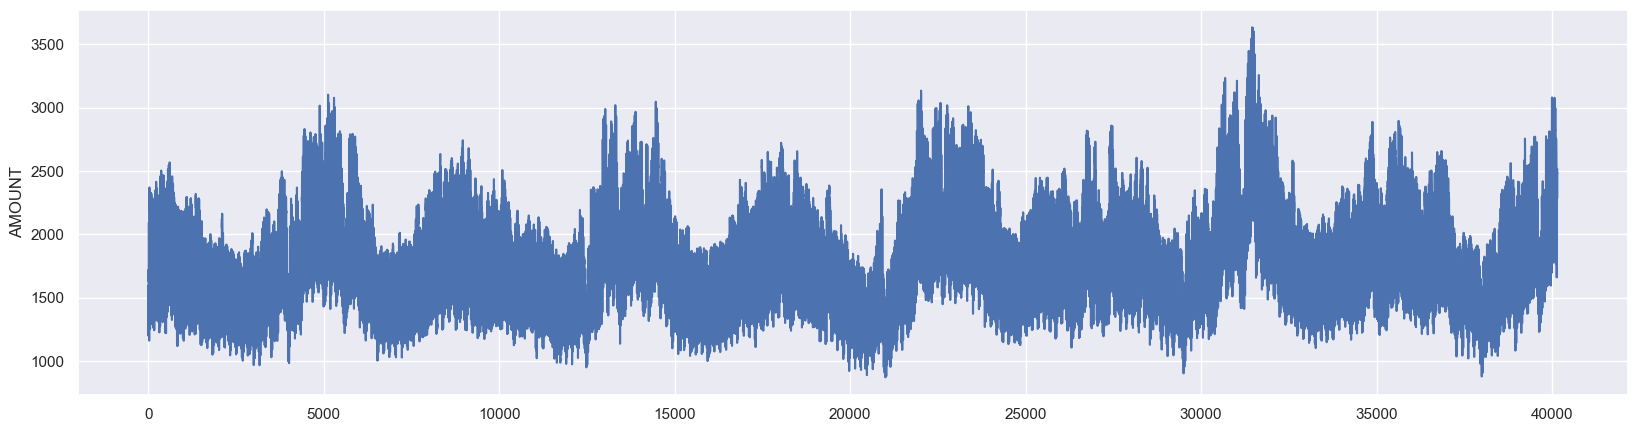

In [22]:
sns.set()

fig, ax = plt.subplots(figsize=(20, 5))
sns.lineplot(data = all_data_train, x=all_data_train.index, y="AMOUNT", ax=ax)

plt.show()

#### 2.1 Yıllık bazda özel aralıkların incelenmesi

In [23]:
def time_graph(DATA, SECONDARY_TIME, DECK):
    pass_df = pd.DataFrame(DATA.groupby(["YEAR",SECONDARY_TIME])["AMOUNT"].agg("mean")).reset_index()
    pass_df[f"YEAR_{SECONDARY_TIME}"] = pass_df["YEAR"].astype("str") +"-"+ pass_df[SECONDARY_TIME].astype("str")

    plt.figure(figsize=(20,5))
    plt.plot(pass_df[f"YEAR_{SECONDARY_TIME}"], pass_df["AMOUNT"])
    plt.title(f"{SECONDARY_TIME}")

    plt.xticks(np.arange(0, pass_df.shape[0], DECK),rotation=90, ha='right')

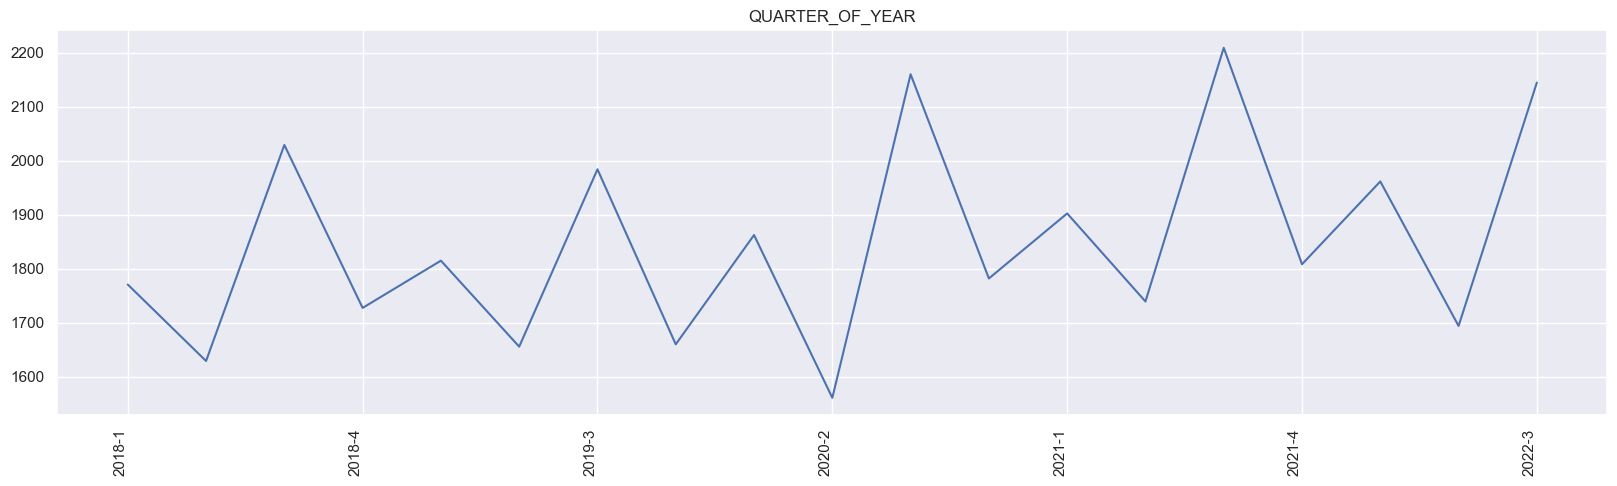

In [24]:
time_graph(all_data_train, "QUARTER_OF_YEAR", 3)

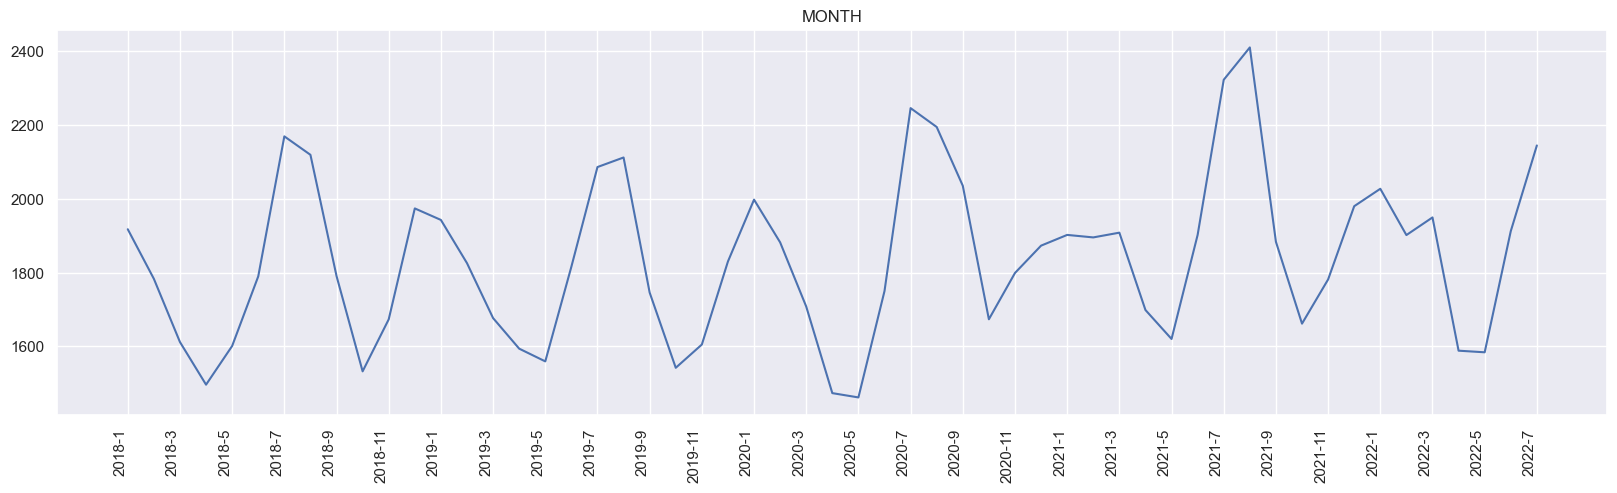

In [25]:
time_graph(all_data_train, "MONTH", 2)

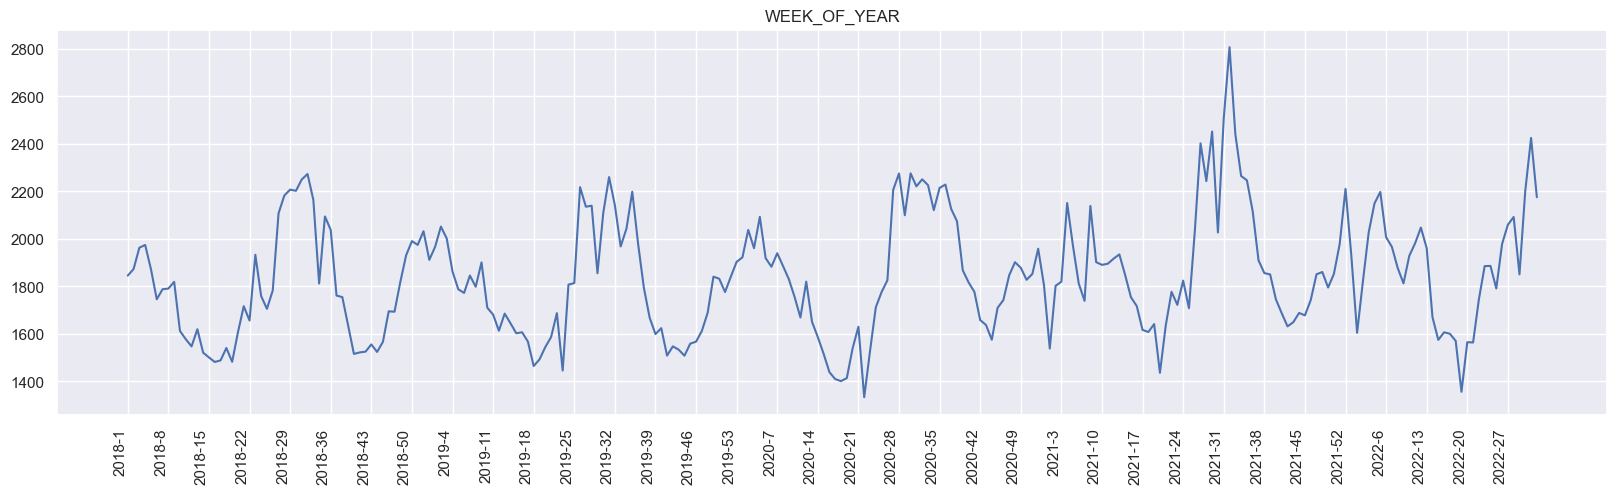

In [26]:
time_graph(all_data_train, "WEEK_OF_YEAR", 7)

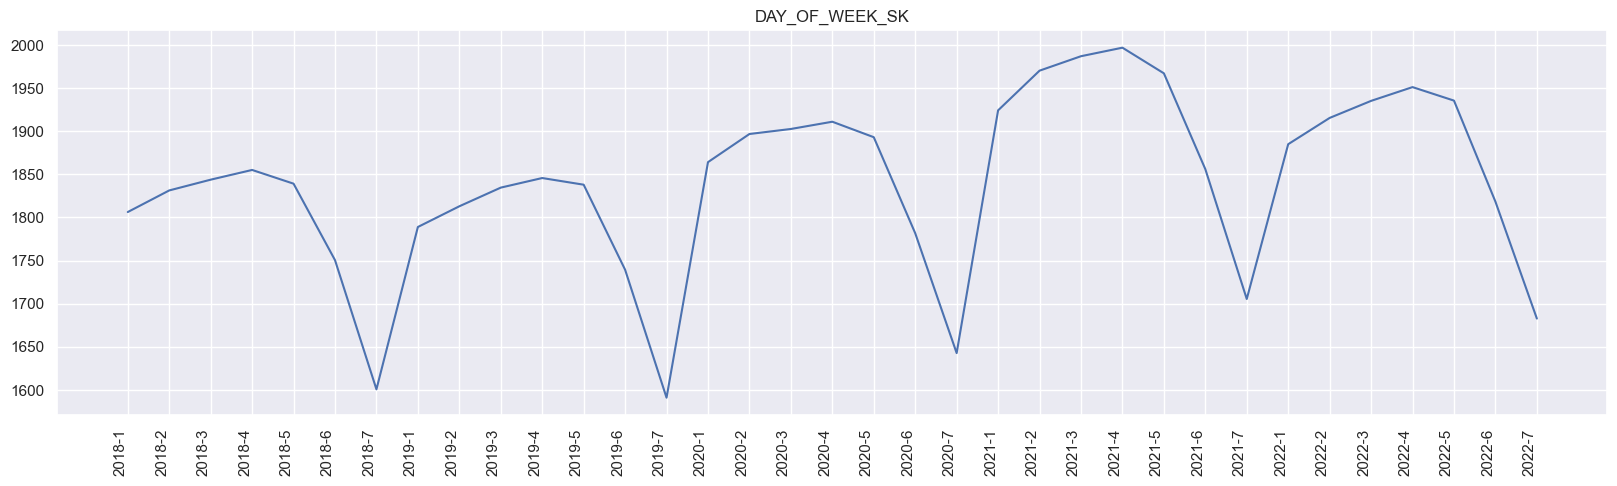

In [27]:
time_graph(all_data_train, "DAY_OF_WEEK_SK", 1)

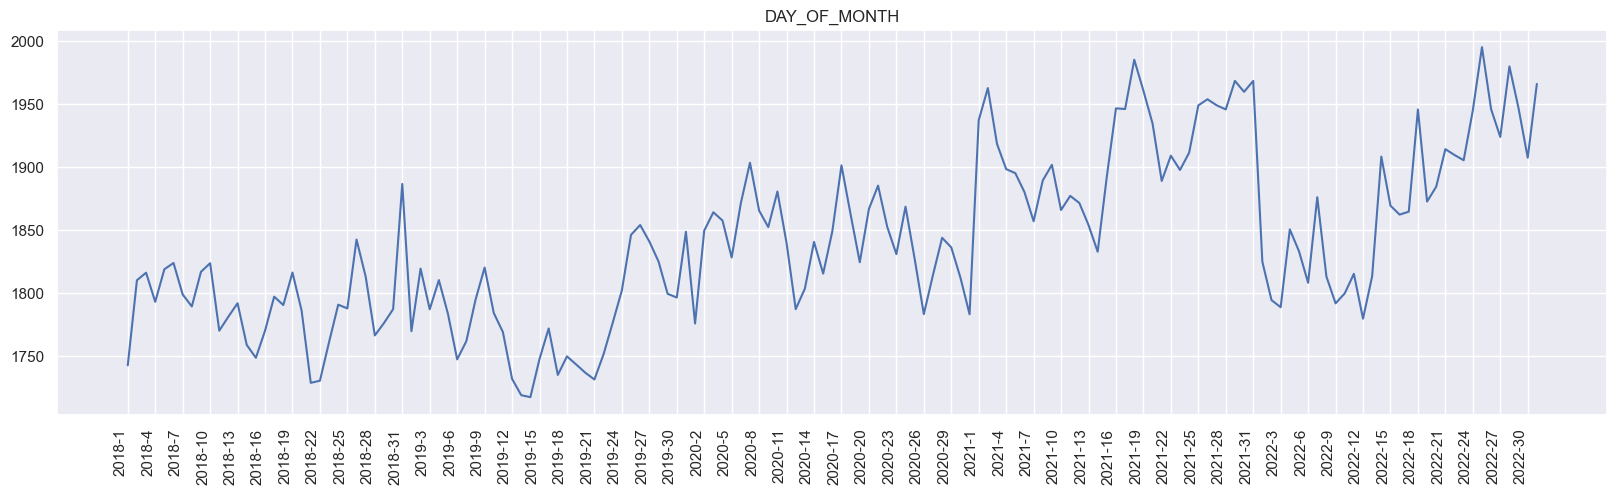

In [28]:
time_graph(all_data_train, "DAY_OF_MONTH", 3)

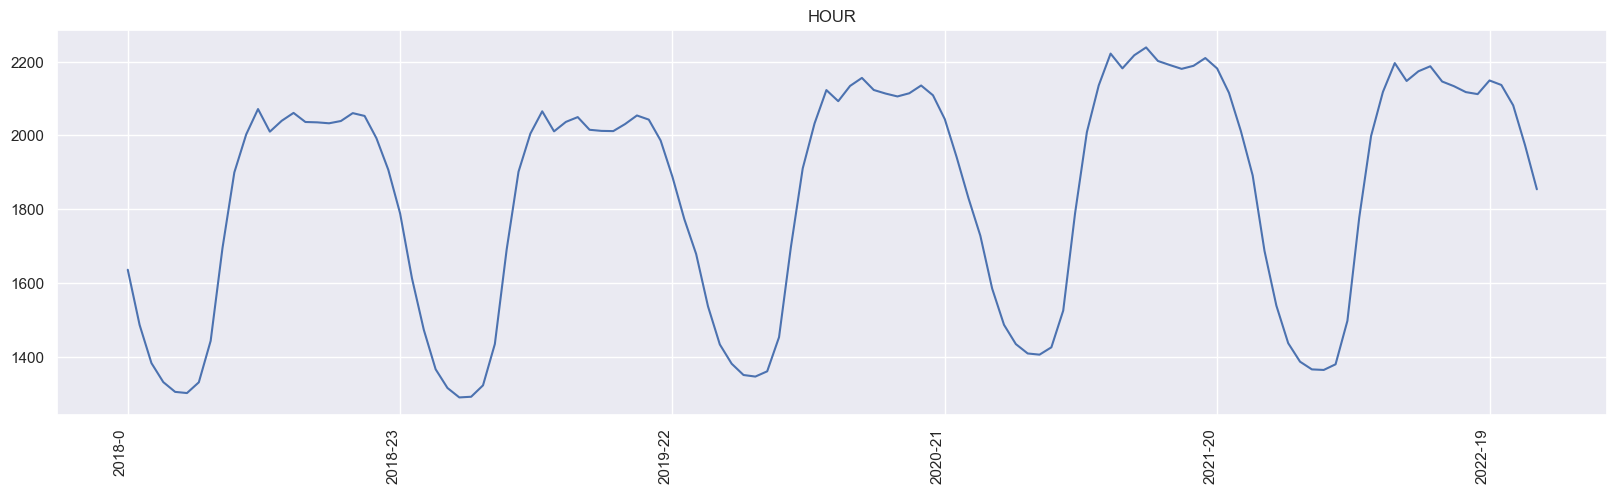

In [29]:
time_graph(all_data_train, "HOUR", 23)

## 2.2-Değişken Türetme

#### 2.2.1. Gece - Gündüz Flag

In [30]:
import pandas as pd
import ephem
import pytz

# Define a function to calculate the sunrise and sunset times for a given location and date
def calculate_sunrise_sunset(row):
    # Set the location coordinates
    location = ephem.Observer()
    location.lat = '38.4237'  # Latitude of Izmir
    location.lon = '27.1428'  # Longitude of Izmir
    
    # Set the date attribute of the location object
    location.date = row['CALENDAR_DATE']
    
    # Calculate the sunrise and sunset times for the specified date
    sunrise_time = location.next_rising(ephem.Sun()).datetime()
    sunset_time = location.next_setting(ephem.Sun()).datetime()
    
    # Convert to local timezone
    local_timezone = pytz.timezone('Europe/Istanbul')
    sunrise_time = sunrise_time.replace(tzinfo=pytz.utc).astimezone(local_timezone)
    sunset_time = sunset_time.replace(tzinfo=pytz.utc).astimezone(local_timezone)
    
    # Return the sunrise and sunset times as a tuple
    return (sunrise_time, sunset_time)

# Create a sample DataFrame with a date column
data = {
    'CALENDAR_DATE': pd.date_range('2018-01-01', '2022-08-31')
}
df = pd.DataFrame(data)

# Apply the calculate_sunrise_sunset function to the date column
df[['sunrise', 'sunset']] = df.apply(calculate_sunrise_sunset, axis=1, result_type='expand')

df['SUNRISE_HOUR'] = df.sunrise.dt.hour
df['SUNSET_HOUR'] = df.sunset.dt.hour
df['SUNSHINE_MINUTE'] =  (df.sunset.dt.hour * 60 + df.sunset.dt.minute) - (df.sunrise.dt.hour * 60 + df.sunrise.dt.minute)

df.drop(columns=["sunrise","sunset"], inplace=True)
df.CALENDAR_DATE = df.CALENDAR_DATE.astype("str")

df.tail()

,CALENDAR_DATE,SUNRISE_HOUR,SUNSET_HOUR,SUNSHINE_MINUTE
1699,2022-08-27,6,19,794
1700,2022-08-28,6,19,791
1701,2022-08-29,6,19,789
1702,2022-08-30,6,19,786
1703,2022-08-31,6,19,784


In [31]:
all_data_train["CALENDAR_DATE"] = all_data[:40152].TARIH_COL.astype(str).str.slice(stop=10).values
all_data_sample["CALENDAR_DATE"] = all_data[40152:].TARIH_COL.astype(str).str.slice(stop=10).values

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [32]:
all_data_train = all_data_train.merge(df, how="left", on="CALENDAR_DATE")
all_data_sample = all_data_sample.merge(df, how="left", on="CALENDAR_DATE")

In [33]:
gece_gunduz_train = []

gece_gunduz_train = ((all_data_train['HOUR'] > all_data_train['SUNRISE_HOUR']) &
               (all_data_train['HOUR'] < all_data_train['SUNSET_HOUR'])).astype(int).tolist()

gece_gunduz_sample = []

gece_gunduz_sample = ((all_data_sample['HOUR'] > all_data_sample['SUNRISE_HOUR']) &
               (all_data_sample['HOUR'] < all_data_sample['SUNSET_HOUR'])).astype(int).tolist()

all_data_train["GUNDUZ_MU"] = gece_gunduz_train
all_data_sample["GUNDUZ_MU"] = gece_gunduz_sample


#### 2.2.4.İzmir - Manisa Ağırlıklandırma

In [34]:
all_data_train["SICAKLIK"] = (all_data_train["temp_IZMIR"]*0.85) + (all_data_train["temp_MANISA"]*0.15)
all_data_train["DWPT"] = (all_data_train["dwpt_IZMIR"]*0.85) + (all_data_train["dwpt_MANISA"]*0.15)
all_data_train["WDIR"] = (all_data_train["wdir_IZMIR"]*0.85) + (all_data_train["wdir_MANISA"]*0.15)
all_data_train["WSPD"] = (all_data_train["wspd_IZMIR"]*0.85) + (all_data_train["wspd_MANISA"]*0.15)
all_data_train["PRES"] = (all_data_train["pres_IZMIR"]*0.85) + (all_data_train["pres_MANISA"]*0.15)
all_data_train["NUFUS_ARTIS_HIZI"] = (all_data_train["İzmir Nüfus Artış Hızı"]*0.85) + (all_data_train["Manisa Nüfus Artış Hızı"]*0.15)
all_data_train["NUFUS_YOGUNLUGU"] = (all_data_train["İzmir Nüfus Yoğunluğu"]*0.85) + (all_data_train["Manisa Nüfus Yoğunluğu"]*0.15)

In [35]:
all_data_sample["SICAKLIK"] = (all_data_sample["temp_IZMIR"]*0.85) + (all_data_sample["temp_MANISA"]*0.15)
all_data_sample["DWPT"] = (all_data_sample["dwpt_IZMIR"]*0.85) + (all_data_sample["dwpt_MANISA"]*0.15)
all_data_sample["WDIR"] = (all_data_sample["wdir_IZMIR"]*0.85) + (all_data_sample["wdir_MANISA"]*0.15)
all_data_sample["WSPD"] = (all_data_sample["wspd_IZMIR"]*0.85) + (all_data_sample["wspd_MANISA"]*0.15)
all_data_sample["PRES"] = (all_data_sample["pres_IZMIR"]*0.85) + (all_data_sample["pres_MANISA"]*0.15)
all_data_sample["NUFUS_ARTIS_HIZI"] = (all_data_sample["İzmir Nüfus Artış Hızı"]*0.85) + (all_data_sample["Manisa Nüfus Artış Hızı"]*0.15)
all_data_sample["NUFUS_YOGUNLUGU"] = (all_data_sample["İzmir Nüfus Yoğunluğu"]*0.85) + (all_data_sample["Manisa Nüfus Yoğunluğu"]*0.15)

#### 2.2.4.Tatil flagler düzenleme

In [36]:
all_data_train['RELIGIOUS_DAY_FLAG_SK'].replace([150, 151, 152, 160, 161, 162, 163], 1, inplace=True)
all_data_train['RELIGIOUS_DAY_FLAG_SK'].replace(100, 1, inplace=True)

all_data_train['NATIONAL_DAY_FLAG_SK'].replace([201, 202, 203, 204], 1, inplace=True)
all_data_train['NATIONAL_DAY_FLAG_SK'].replace(200, 0, inplace=True)

In [37]:
all_data_sample['RELIGIOUS_DAY_FLAG_SK'].replace([150, 151, 152, 160, 161, 162, 163], 1, inplace=True)
all_data_sample['RELIGIOUS_DAY_FLAG_SK'].replace(100, 1, inplace=True)

all_data_sample['NATIONAL_DAY_FLAG_SK'].replace([201, 202, 203, 204], 1, inplace=True)
all_data_sample['NATIONAL_DAY_FLAG_SK'].replace(200, 0, inplace=True)

#### 2.2.5.Elektrik Fiyatlar Düzenleme

In [38]:
ALL_HOLIDAY_FLAG_train = ((all_data_train['WEEKEND_FLAG'] == 1) |
                    (all_data_train['RAMADAN_FLAG'] == 1) |
                    (all_data_train['RELIGIOUS_DAY_FLAG_SK'] == 1) | 
                    (all_data_train['NATIONAL_DAY_FLAG_SK'] == 1) | 
                    (all_data_train['PUBLIC_HOLIDAY_FLAG'] == 1) ).astype(int).tolist() 

ALL_HOLIDAY_FLAG_test = ((all_data_sample['WEEKEND_FLAG'] == 1) |
                    (all_data_sample['RAMADAN_FLAG'] == 1) |
                    (all_data_sample['RELIGIOUS_DAY_FLAG_SK'] == 1) | 
                    (all_data_sample['NATIONAL_DAY_FLAG_SK'] == 1) | 
                    (all_data_sample['PUBLIC_HOLIDAY_FLAG'] == 1) ).astype(int).tolist() 

all_data_train["ALL_HOLIDAY_FLAG"] = ALL_HOLIDAY_FLAG_train
all_data_sample["ALL_HOLIDAY_FLAG"] = ALL_HOLIDAY_FLAG_test

#### 2.2.6.Kullanılan Alanların Silinmesi

In [39]:
all_data_train_2 = all_data_train.drop(columns= ['temp_IZMIR', 'dwpt_IZMIR', 'rhum_IZMIR', 'wdir_IZMIR', 'wspd_IZMIR',
       'pres_IZMIR', 'temp_MANISA', 'dwpt_MANISA', 'rhum_MANISA',
       'wdir_MANISA', 'wspd_MANISA', 'pres_MANISA', 'İzmir Nüfusu',
       'İzmir Nüfus Artış Hızı', 'İzmir Nüfus Yoğunluğu', 'Manisa Nüfusu',
       'Manisa Nüfus Artış Hızı', 'Manisa Nüfus Yoğunluğu',
      "SUNRISE_HOUR", "SUNSET_HOUR",'CALENDAR_DATE', "WEEKEND_FLAG",
      "RAMADAN_FLAG","RELIGIOUS_DAY_FLAG_SK","NATIONAL_DAY_FLAG_SK","PUBLIC_HOLIDAY_FLAG", "HOUR"])

In [40]:
all_data_sample_2 = all_data_sample.drop(columns= ['temp_IZMIR', 'dwpt_IZMIR', 'rhum_IZMIR', 'wdir_IZMIR', 'wspd_IZMIR',
       'pres_IZMIR', 'temp_MANISA', 'dwpt_MANISA', 'rhum_MANISA',
       'wdir_MANISA', 'wspd_MANISA', 'pres_MANISA', 'İzmir Nüfusu',
       'İzmir Nüfus Artış Hızı', 'İzmir Nüfus Yoğunluğu', 'Manisa Nüfusu',
       'Manisa Nüfus Artış Hızı', 'Manisa Nüfus Yoğunluğu',
       "SUNRISE_HOUR", "SUNSET_HOUR",'CALENDAR_DATE', "WEEKEND_FLAG",
       "RAMADAN_FLAG","RELIGIOUS_DAY_FLAG_SK","NATIONAL_DAY_FLAG_SK","PUBLIC_HOLIDAY_FLAG", "HOUR"])

## 2.3.Numerik Analiz

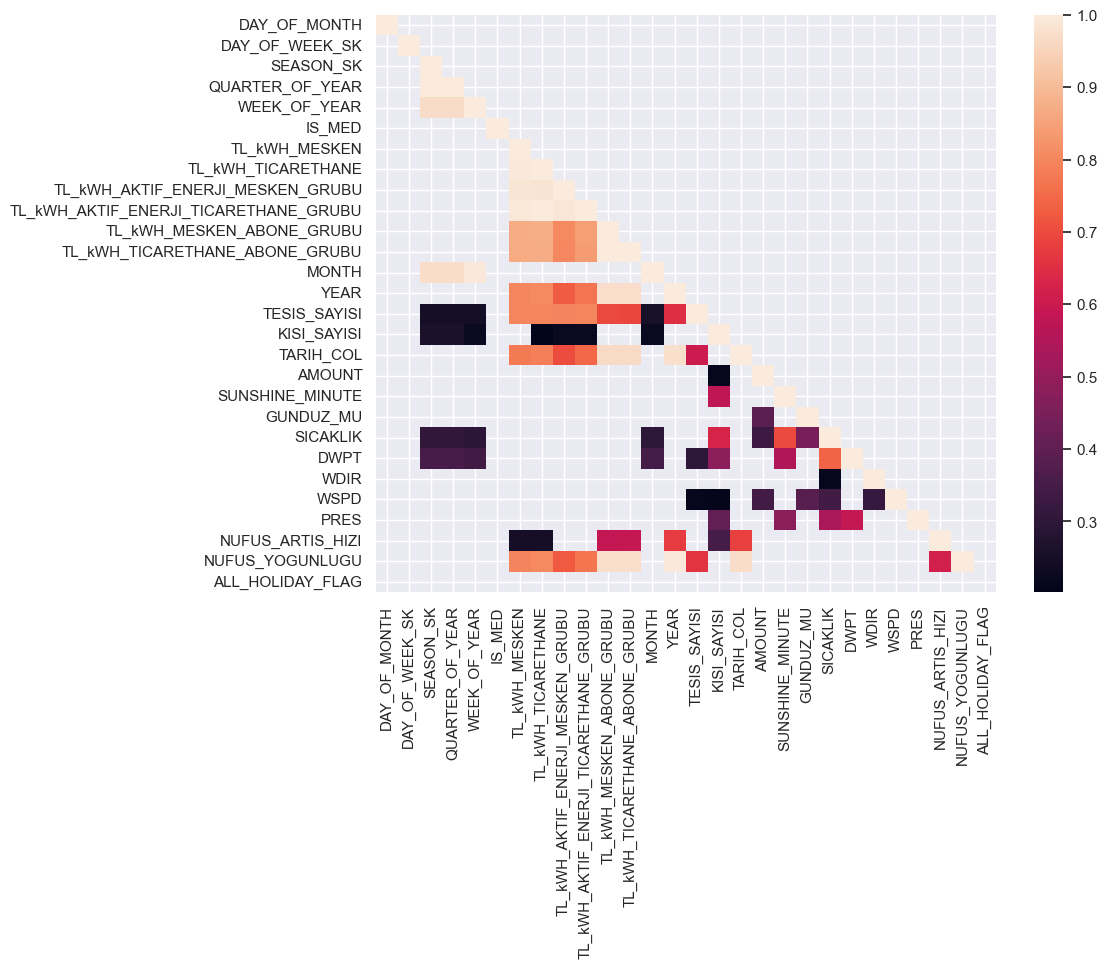

In [41]:
# Showing the correlations
correlations = all_data_train_2.corr().abs()
correlations = correlations[correlations > 0.2]


df_lt = correlations.where(np.tril(np.ones(correlations.shape)).astype(np.bool_))

sns.set(rc={'figure.figsize': (10, 7.5)})
sns.heatmap(df_lt)
plt.show(block=True)

In [42]:
all_data_train_3 = all_data_train_2.set_index("TARIH_COL")

# 3-Test_Train Split

In [43]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import sklearn.preprocessing
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from keras.layers import Dense,Dropout,SimpleRNN,LSTM, Flatten
from keras.models import Sequential, load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import  Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler



In [83]:
# Split the dataset into training and testing sets
X = all_data_train_3.drop(columns='AMOUNT', axis=1)  

# drop the target column from the features
y = all_data_train_3['AMOUNT']  

# transform data
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)

# set the target column as the labels
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=42, shuffle=False)

# Print the shapes of the train and test sets
print('Training set shape:', X_train.shape, y_train.shape)
print('Testing set shape:', X_test.shape, y_test.shape)

Training set shape: (32121, 26) (32121,)
Testing set shape: (8031, 26) (8031,)


# 3-Model  LightGBMRegressor

In [84]:
# For our dl model we will create windows of data that will be feeded into the datasets, for each timestemp T we will append the data from T-7 to T to the Xdata with target Y(t)
BATCH_SIZE = 64
BUFFER_SIZE = 100
WINDOW_LENGTH = 24


def window_data(X, Y, window=7):
    '''
    The dataset length will be reduced to guarante all samples have the window, so new length will be len(dataset)-window
    '''
    x = []
    y = []
    for i in range(window-1, len(X)):
        x.append(X[i-window+1:i+1])
        y.append(Y[i])
    return np.array(x), np.array(y)


# Since we are doing sliding, we need to join the datasets again of train and test
X_w = np.concatenate((X_train, X_test))
y_w = np.concatenate((y_train, y_test))

X_w, y_w = window_data(X_w, y_w, window=WINDOW_LENGTH)
X_train_w = X_w[:-len(X_test)]
y_train_w = y_w[:-len(X_test)]
X_test_w = X_w[-len(X_test):]
y_test_w = y_w[-len(X_test):]

# Check we will have same test set as in the previous models, make sure we didnt screw up on the windowing
print(f"Test set equal: {np.array_equal(y_test_w,y_test)}")

train_data = tf.data.Dataset.from_tensor_slices((X_train_w, y_train_w))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((X_test_w, y_test_w))
val_data = val_data.batch(BATCH_SIZE).repeat()

Test set equal: True


In [89]:
dropout = 0.1
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(
        128, input_shape=X_train_w.shape[-2:], dropout=dropout),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(1)
])


lstm_model.summary()
# logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S") #Support for tensorboard tracking!
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 128)               79360     
                                                                 
 dense_24 (Dense)            (None, 128)               16512     
                                                                 
 dense_25 (Dense)            (None, 128)               16512     
                                                                 
 dense_26 (Dense)            (None, 1)                 129       
                                                                 
Total params: 112,513
Trainable params: 112,513
Non-trainable params: 0
_________________________________________________________________


In [94]:
 # Compile the model
learning_rate = 0.01

optimizer = Adam(learning_rate=learning_rate)

lstm_model.compile(loss='MAPE', metrics= tf.keras.metrics.MeanAbsolutePercentageError(), optimizer=optimizer, run_eagerly=True)

callbacks = [
              ModelCheckpoint(
                filepath="epoch{epoch:02d}.h5",
            # Path where to save the model
            # We will save a model if its validation loss gets increased compared to the previous epoch
                save_best_only=True,
                monitor='val_loss',
                verbose=1),
            # An early stopper to help blocking overfitting  
              EarlyStopping(
                monitor = 'val_loss',
                patience = 10)] # The model will stop itself after ten epoch if it can't increase its validation loss

  

fold_history = lstm_model.fit(train_data,
                                epochs=100,
                                steps_per_epoch=EVALUATION_INTERVAL,
                                callbacks=callbacks,
                                validation_data=val_data,
                                validation_steps=50
                                )

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 21.7799 - mean_absolute_percentage_error: 21.7799
Epoch 1: val_loss improved from inf to 21.34190, saving model to epoch01.h5
200/200 [==============================] - 16s 80ms/step - loss: 21.7799 - mean_absolute_percentage_error: 21.7799 - val_loss: 21.3419 - val_mean_absolute_percentage_error: 21.3419
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 19.0217 - mean_absolute_percentage_error: 19.0217
Epoch 2: val_loss improved from 21.34190 to 18.16711, saving model to epoch02.h5
200/200 [==============================] - 16s 81ms/step - loss: 19.0217 - mean_absolute_percentage_error: 19.0217 - val_loss: 18.1671 - val_mean_absolute_percentage_error: 18.1671
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 19.4291 - mean_absolute_percentage_error: 19.4291
Epoch 3: val_loss did not improve from 18.16711
200/200 [==============================] - 16s 81ms/step - loss: 19.42

## 3.1.Model Sonuç Zaman Grafiği

In [125]:
all_data_sample_3 = all_data_sample_2.drop(columns="AMOUNT").set_index("TARIH_COL")

In [118]:


deneme, y_dvfddfw = window_data(scaled_Sample, y_w, window=WINDOW_LENGTH)



In [119]:
deneme.shape

(721, 24, 26)

In [117]:
X_test_w.shape

(8031, 24, 26)

In [103]:
yhat = lstm_model.predict(X_test_w).reshape(1, -1)[0]
yhat

251/251 [==============================] - 6s 23ms/step


array([1568.8082, 1568.8073, 1568.8414, ..., 1350.8005, 1350.8323,
       1350.9012], dtype=float32)

In [98]:
scaled_Sample

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.        , 0.33333333, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.33333333, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.33333333, 0.        , ..., 0.        , 0.        ,
        0.        ]])

23/23 [==============================] - 1s 23ms/step


array([[<Axes: title={'center': '0'}>]], dtype=object)

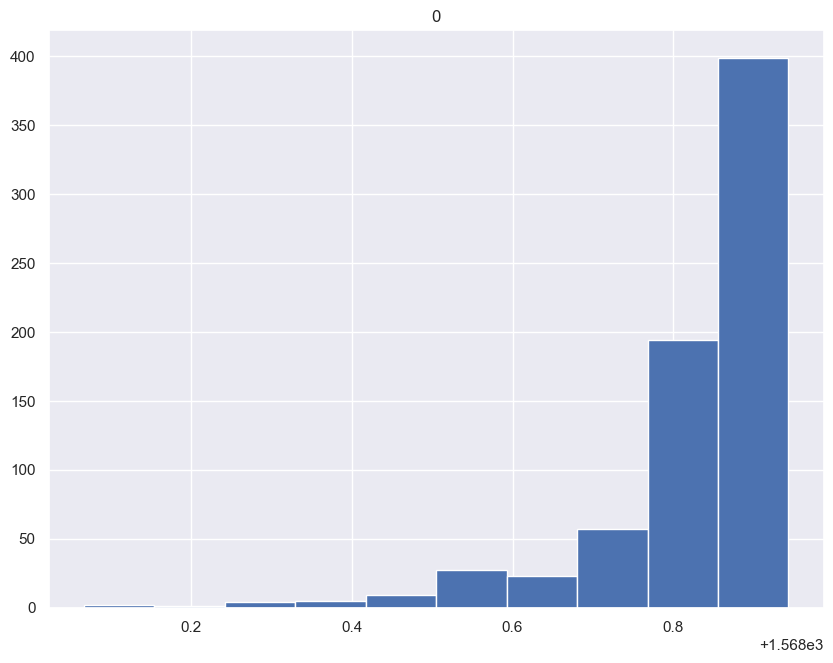

In [121]:
# transform data
scaler = MinMaxScaler()
scaled_Sample = scaler.fit_transform(all_data_sample_3)

# Make predictions on the new input sequences
predictions = lstm_model.predict(deneme)

# Print the predicted values
pd.DataFrame(predictions).hist()

In [128]:
pd.DataFrame(predictions)

,0
0,1568.857544
1,1568.856567
2,1568.856445
3,1568.855469
4,1568.819824
...,...
716,1568.843750
717,1568.791992
718,1568.733276
719,1568.769043


In [129]:
sample["Dağıtılan Enerji (MWh)"] = pd.DataFrame(predictions).values
sample = sample.set_index("Tarih")

ValueError: Length of values (721) does not match length of index (744)

In [ ]:
all_data_train_4 = all_data_train_2
all_data_train_4["TARIH_COL"] = all_data[:40152]["TARIH_COL"]
all_data_train_4.set_index("TARIH_COL", inplace=True)

In [ ]:
deneme = sample.copy()

array([[<Axes: title={'center': 'Dağıtılan Enerji (MWh)'}>]], dtype=object)

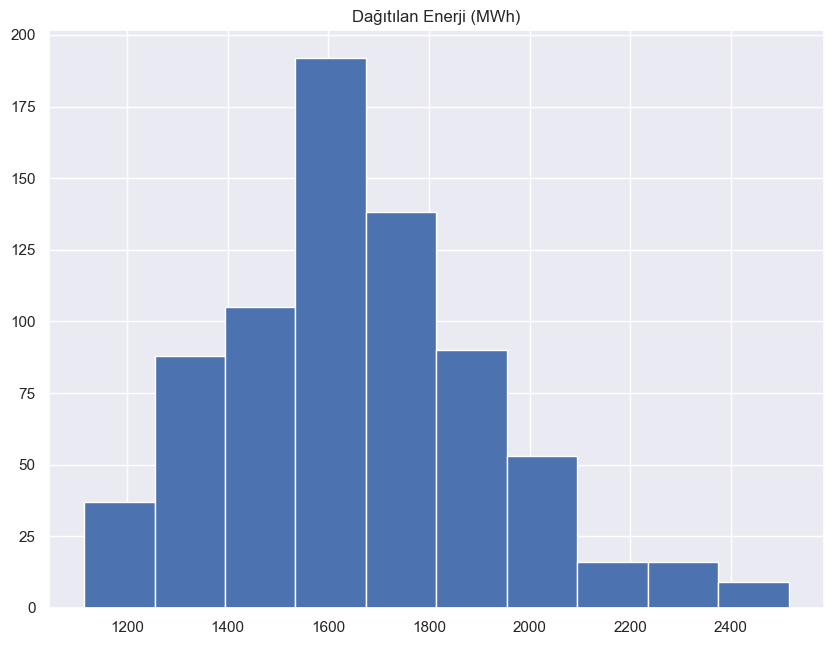

In [ ]:
deneme.hist()

In [ ]:
deneme["Dağıtılan Enerji (MWh)"] = deneme["Dağıtılan Enerji (MWh)"]

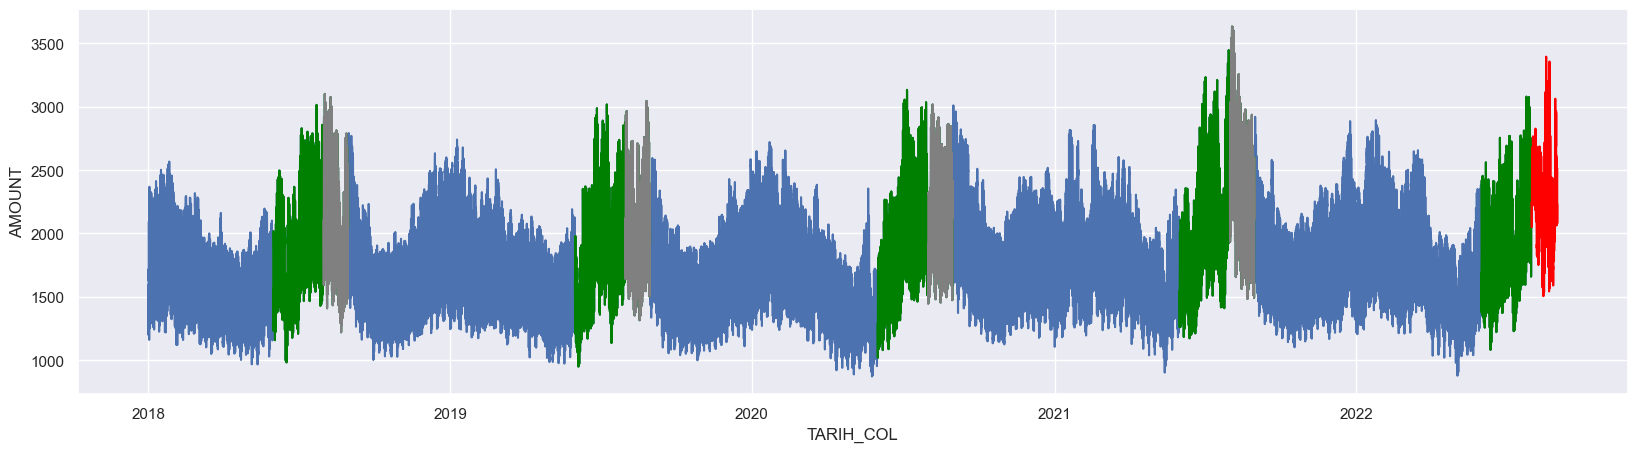

In [ ]:
sns.set()

fig, ax = plt.subplots(figsize=(20, 5))
sns.lineplot(data = all_data_train_4, x=all_data_train_4.index, y="AMOUNT", ax=ax)
sns.lineplot(data = all_data_train_4['2018-06-01 00:00:00':'2018-08-30 23:00:00'], x=all_data_train_4['2018-06-01 00:00:00':'2018-08-30 23:00:00'].index, y="AMOUNT", ax=ax, color="green")
sns.lineplot(data = all_data_train_4['2019-06-01 00:00:00':'2019-08-30 23:00:00'], x=all_data_train_4['2019-06-01 00:00:00':'2019-08-30 23:00:00'].index, y="AMOUNT", ax=ax, color="green")
sns.lineplot(data = all_data_train_4['2020-06-01 00:00:00':'2020-08-30 23:00:00'], x=all_data_train_4['2020-06-01 00:00:00':'2020-08-30 23:00:00'].index, y="AMOUNT", ax=ax, color="green")
sns.lineplot(data = all_data_train_4['2021-06-01 00:00:00':'2021-08-30 23:00:00'], x=all_data_train_4['2021-06-01 00:00:00':'2021-08-30 23:00:00'].index, y="AMOUNT", ax=ax, color="green")
sns.lineplot(data = all_data_train_4['2018-08-01 00:00:00':'2018-08-30 23:00:00'], x=all_data_train_4['2018-08-01 00:00:00':'2018-08-30 23:00:00'].index, y="AMOUNT", ax=ax, color="grey")
sns.lineplot(data = all_data_train_4['2019-08-01 00:00:00':'2019-08-30 23:00:00'], x=all_data_train_4['2019-08-01 00:00:00':'2019-08-30 23:00:00'].index, y="AMOUNT", ax=ax, color="grey")
sns.lineplot(data = all_data_train_4['2020-08-01 00:00:00':'2020-08-30 23:00:00'], x=all_data_train_4['2020-08-01 00:00:00':'2020-08-30 23:00:00'].index, y="AMOUNT", ax=ax, color="grey")
sns.lineplot(data = all_data_train_4['2021-08-01 00:00:00':'2021-08-30 23:00:00'], x=all_data_train_4['2021-08-01 00:00:00':'2021-08-30 23:00:00'].index, y="AMOUNT", ax=ax, color="grey")
sns.lineplot(data = all_data_train_4['2022-06-01 00:00:00':'2022-08-30 23:00:00'], x=all_data_train_4['2022-06-01 00:00:00':'2022-08-30 23:00:00'].index, y="AMOUNT", ax=ax, color="green")
sns.lineplot(data = deneme, x=deneme.index, y="Dağıtılan Enerji (MWh)", ax=ax, color="red")

plt.show()

plt.show()

In [ ]:
deneme.to_csv("GDZ_Datathon_202304_LGBM_V5.csv")

In [ ]:
from sklearn import preprocessing

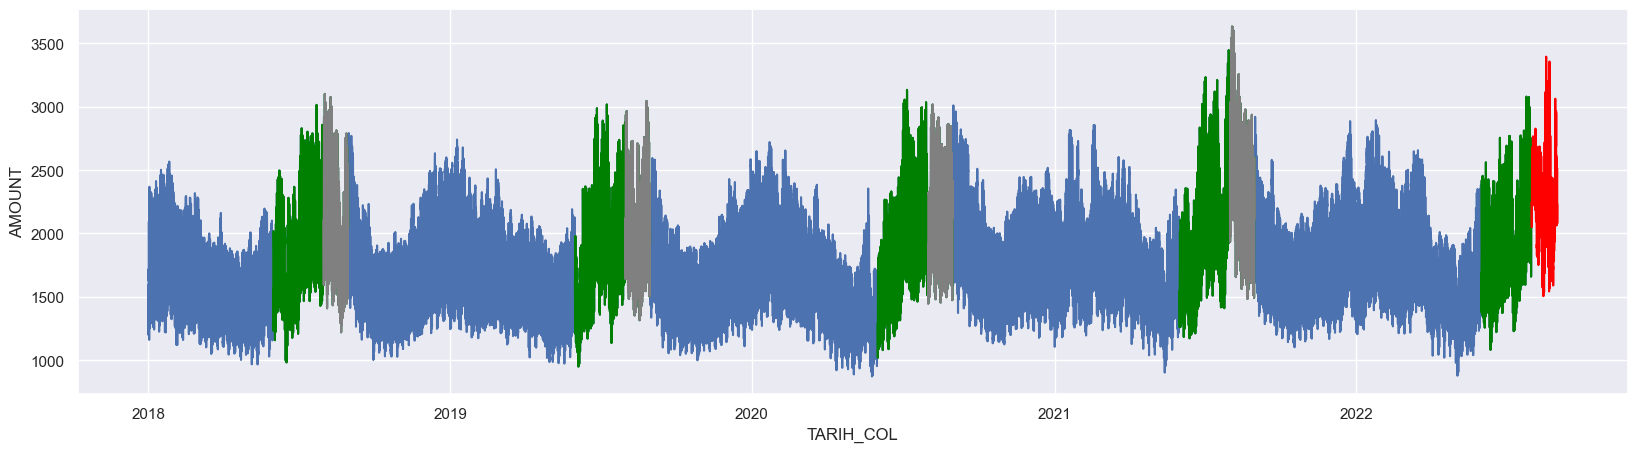